In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

In [91]:
# Load CSV dataset
df = pd.read_csv('preprocessed_Dataset_Coder_Smasher.csv')

In [92]:
# Flatten time-series in the dataset
hourly_aqi = df.drop(columns=["Days"]).values.flatten()

In [93]:
# Clip outliers (in 1-99 range)
lower_bound = np.percentile(hourly_aqi, 1)
upper_bound = np.percentile(hourly_aqi, 99)
hourly_aqi = np.clip(hourly_aqi, lower_bound, upper_bound)

In [94]:
# AQI category separation (Based on India AQI standard)
def aqi_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe"

In [95]:
# Create sequences 1D AQI ---> 6 windows
def create_sequences(data, window=6):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(aqi_category(data[i+window]))
    return np.array(X), np.array(y)

window_size = 6
X, y = create_sequences(hourly_aqi, window=window_size)

In [96]:
# Encode labels (categorical labels ----> input values for model)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [97]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, shuffle=False)

In [98]:
# Train classifier (Initializes and trains an XGBoost model on the AQI sequences)
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:58:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [80]:
# Input 6 latest AQI values
print("Enter 6 AQI values separated by commas (e.g. 270,285,300,310,320,330):")
user_input = input().strip()
input_values = np.array([float(x) for x in user_input.split(",")])

Enter 6 AQI values separated by commas (e.g. 270,285,300,310,320,330):
23,45,67,89,45,89


In [81]:
# Preprocess input (clip using training bounds)
input_values = np.clip(input_values, lower_bound, upper_bound).reshape(1, -1)

In [82]:
# Predict
prediction = model.predict(input_values)
predicted_label = label_encoder.inverse_transform(prediction)[0]

In [101]:
print(f"\n Predicted AQI Category: {predicted_label}")


 Predicted AQI Category: Moderate


In [84]:
# Get predictions on the test set
y_pred = model.predict(X_test)

In [85]:
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

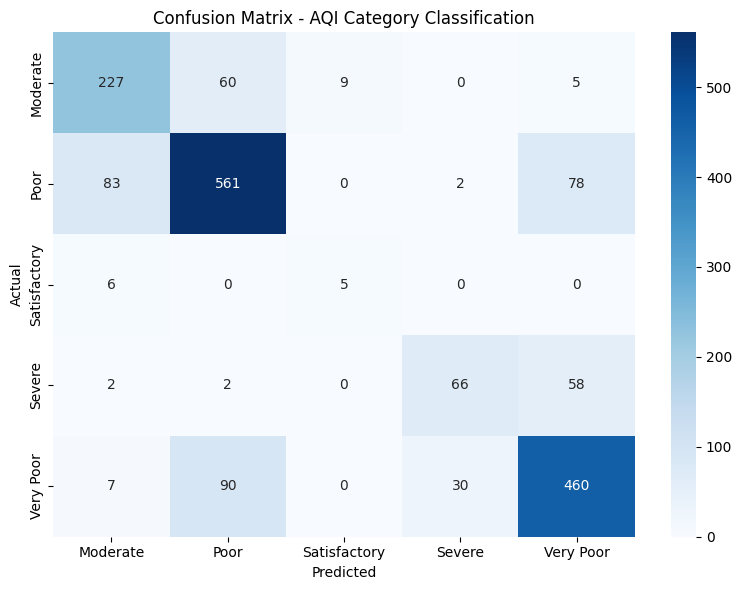

In [86]:
plt.figure(figsize=(8,6))
sns.heatmap(
    confusion_matrix(y_test_labels, y_pred_labels),  # the matrix itself
    annot=True,                             # show numbers inside boxes
    fmt='d',                                # integer format
    cmap='Blues',                           # blue color palette
    xticklabels=label_encoder.classes_,        # predicted category labels
    yticklabels=label_encoder.classes_         # actual category labels
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - AQI Category Classification")
plt.tight_layout()
plt.show()


<ipython-input-87-ddddfdb2f9e1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


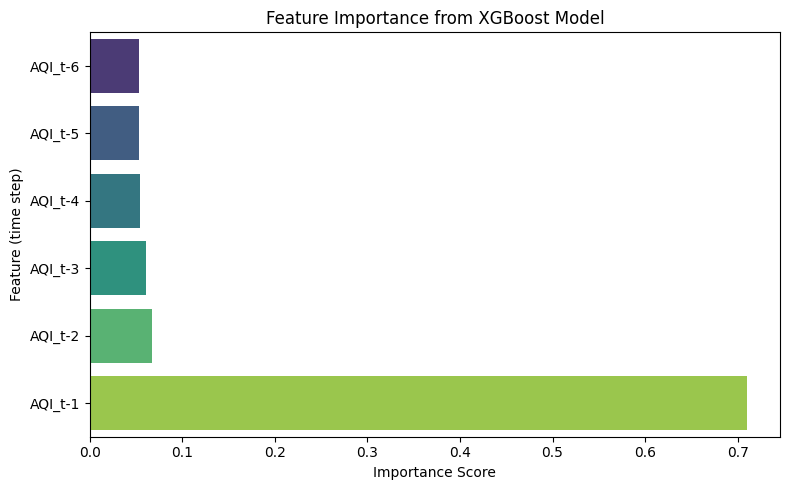

In [87]:
# Feature Importance (Visualisation of past AQIs importance in determining result)
importances = model.feature_importances_
feature_names = [f"AQI_t-{window_size - i}" for i in range(window_size)]

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature (time step)")
plt.title("Feature Importance from XGBoost Model")
plt.tight_layout()
plt.show()

In [88]:
# Predict class probabilities
y_pred_probs = model.predict_proba(X_test)

# Calculate AUC-ROC Score
auc_score = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print("AUC-ROC Score:", auc_score)


AUC-ROC Score: 0.9334427152460061


In [100]:
# Model Evaluation Summary
print(":) Team - Code Smasher....Model Evaluation Metrics")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("AUC-ROC Score:", auc_score)
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

:) Team - Code Smasher....Model Evaluation Metrics
Accuracy: 0.7532838378069674
F1 Score: 0.752331053331497
AUC-ROC Score: 0.9334427152460061

Classification Report:
               precision    recall  f1-score   support

    Moderate       0.70      0.75      0.73       301
        Poor       0.79      0.77      0.78       724
Satisfactory       0.36      0.45      0.40        11
      Severe       0.67      0.52      0.58       128
   Very Poor       0.77      0.78      0.77       587

    accuracy                           0.75      1751
   macro avg       0.66      0.66      0.65      1751
weighted avg       0.75      0.75      0.75      1751

